# An extension of 4
Here we show how to build a basic neural network for identifying dog or muffin

In [1]:
%matplotlib inline
import os
from IPython.display import display
import numpy as np  # linear algebra / matrices
from skimage.color import label2rgb
from sklearn.metrics import roc_curve, auc  # roc curve tools
from skimage.segmentation import mark_boundaries  # mark labels
from skimage.io import imread  # read in images
import matplotlib.pyplot as plt  # plotting

In [2]:
base_path = '04-files'
seg_path = os.path.join(base_path, 'DogVsMuffin_seg_bw.jpg')
rgb_path = os.path.join(base_path, 'DogVsMuffin.jpg')
face_path = os.path.join(base_path, 'DogVsMuffin_face.jpg')
seg_img = imread(seg_path)[80:520:2, :450:2]
rgb_img = imread(rgb_path)[80:520:2, :450:2, :]
face_img = imread(face_path)
print('RGB Size', rgb_img.shape, 'Seg Size',
      seg_img.shape, 'Face Size', face_img.shape)

RGB Size (220, 225, 3) Seg Size (220, 225) Face Size (111, 131, 3)


# Calculate the baseline ROC curve

In [3]:
ground_truth_labels = seg_img.flatten() > 0
score_value = 1-np.mean(rgb_img.astype(np.float32), 2).flatten()/255.0
fpr, tpr, _ = roc_curve(ground_truth_labels, score_value)
roc_auc = auc(fpr, tpr)

Text(0.5, 1.0, 'Labeled Image')

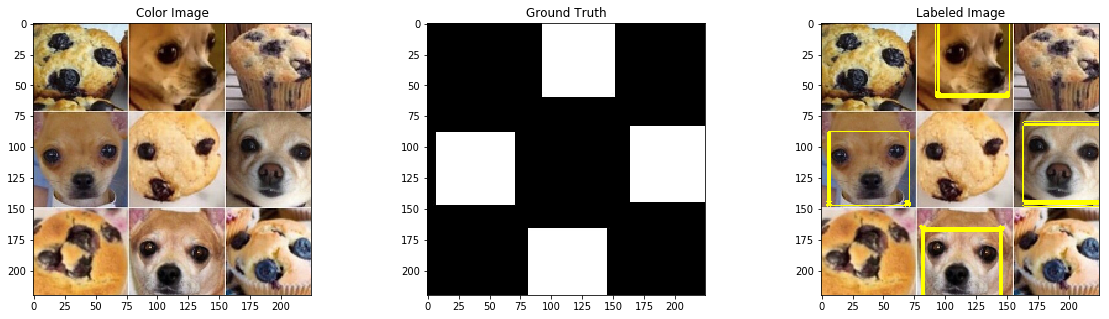

In [4]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(rgb_img)  # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, cmap='gray')  # show the segments
ax2.set_title("Ground Truth")
ax3.imshow(mark_boundaries(rgb_img, seg_img))
ax3.set_title("Labeled Image")

# Build the Model
We use a library called [Keras](https://keras.io/) which lets us easily build models and avoid making easy mistakes. We focus here on just a single convolutional layers with dimensions 25x25.

### Data Preparation
We need to redimnsion the arrays to use them in deep learning libraries. Keras and Tensorflow use the forman BHWC (Batch, Height, Width, Channels) since we just have a single item in our batch we can use `np.expand_dims` to add that dimension.

In [5]:
img_tensor = np.expand_dims(rgb_img, 0)/255.0
seg_tensor = np.expand_dims(np.expand_dims(seg_img/255.0, -1), 0)

In [6]:
from keras import models, layers, optimizers
simple_model = models.Sequential(name='SingleConvLayer')
# learn one convolution layer
kernel_dim = 12
np.random.seed(2019)
init_W = np.random.normal(0, 0.02, size=(kernel_dim, kernel_dim, 3, 1))
simple_model.add(layers.Conv2D(1, 
                               kernel_size=(kernel_dim, kernel_dim),
                               input_shape = (None, None, 3),
                               use_bias=False,
                               weights=[init_W],
                               activation='sigmoid',
                               padding='same'))
# the optimizer (how the model is updated)
# loss (what is are we trying to minimize)
# metrics (how we measure the performance)
simple_model.compile(optimizer=optimizers.SGD(lr=5e-3),
                     loss='binary_crossentropy',
                     metrics=['binary_accuracy', 'mse'])
simple_model.summary()

/Users/kevinmader/miniconda3/envs/qbi2019/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 1)     432       
Total params: 432
Trainable params: 432
Non-trainable params: 0
_________________________________________________________________


In [7]:
simple_model.fit(img_tensor,
                 seg_tensor,
                 epochs=1)

Epoch 1/1
1/1 [==============================] - 0s 309ms/step - loss: 0.6863 - binary_accuracy: 0.5788 - mean_squared_error: 0.2465


Text(0.5, 1.0, 'CNN Prediction')

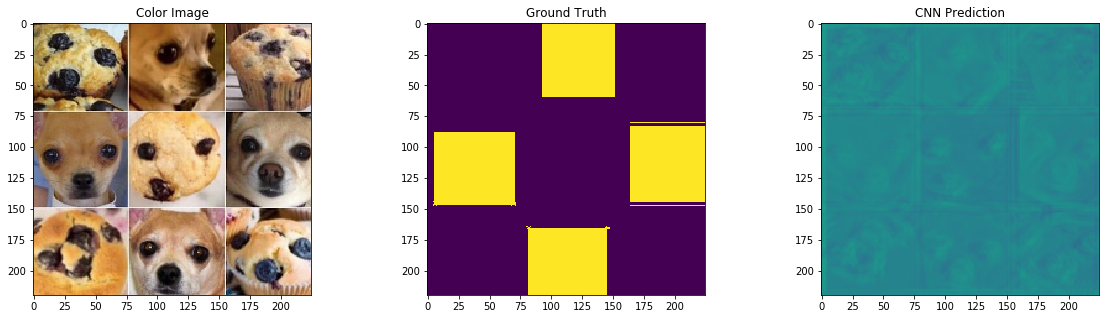

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(rgb_img)  # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, vmin=0, vmax=1, cmap='viridis')  # show the segments
ax2.set_title("Ground Truth")
m_output = simple_model.predict(img_tensor)
ax3.imshow(m_output[0, :, :, 0], vmin=0, vmax=1, cmap='viridis')
ax3.set_title("CNN Prediction")

In [9]:
loss_history = simple_model.fit(img_tensor,
                                seg_tensor,
                                epochs=10,
                                verbose=False)
print('Pixel Level Accuracy: {:2.1%}'.format(loss_history.history['binary_accuracy'][-1]))

Pixel Level Accuracy: 70.2%


Text(0.5, 1.0, 'CNN Prediction')

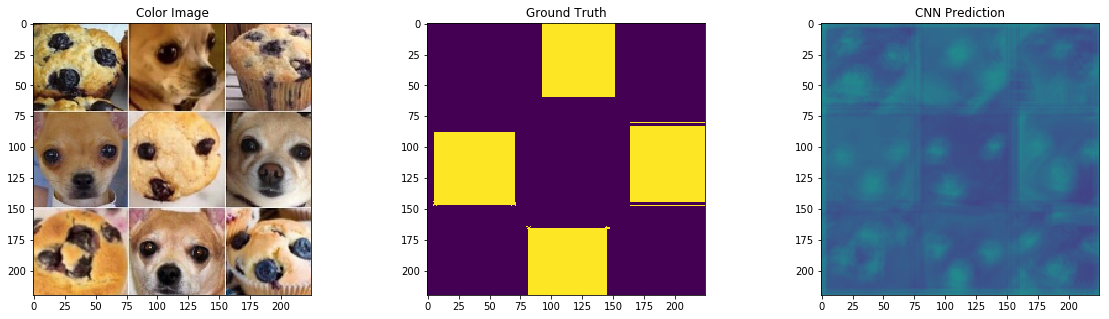

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(rgb_img)  # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, vmin=0, vmax=1, cmap='viridis')  # show the segments
ax2.set_title("Ground Truth")
m_output = simple_model.predict(img_tensor)
ax3.imshow(m_output[0, :, :, 0], vmin=0, vmax=1, cmap='viridis')
ax3.set_title("CNN Prediction")

In [11]:
fpr_cnn, tpr_cnn, _ = roc_curve(ground_truth_labels, m_output.ravel())
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

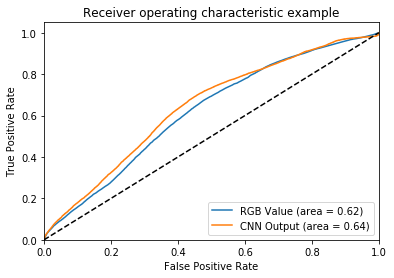

In [12]:
fig, ax = plt.subplots(1, 1)
ax.plot(fpr, tpr, label='RGB Value (area = %0.2f)' % roc_auc)
ax.plot(fpr_cnn, tpr_cnn, label='CNN Output (area = %0.2f)' % roc_auc_cnn)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

## Augmentation
We use the augmentation methods covered in the Datasets lecture to increase the amount of data we have and make the model less sennsitive to small changes.

In [13]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(rotation_range=2,
                         zoom_range=0.1,
                         width_shift_range=.1,
                         height_shift_range=0.1,
                         vertical_flip=True,
                         horizontal_flip=True)
img_gen = idg.flow(img_tensor, seed=1234)
seg_gen = idg.flow(seg_tensor, seed=1234)

In [14]:
simple_model.fit_generator(zip(img_gen, seg_gen), 
                           steps_per_epoch=20, 
                           epochs=5)

Epoch 1/5
20/20 [==============================] - 3s 131ms/step - loss: 0.5814 - binary_accuracy: 0.7063 - mean_squared_error: 0.1973
Epoch 2/5
20/20 [==============================] - 3s 142ms/step - loss: 0.5825 - binary_accuracy: 0.7028 - mean_squared_error: 0.1980
Epoch 3/5
20/20 [==============================] - 3s 142ms/step - loss: 0.5821 - binary_accuracy: 0.7031 - mean_squared_error: 0.1979
Epoch 4/5
20/20 [==============================] - 2s 122ms/step - loss: 0.5785 - binary_accuracy: 0.7060 - mean_squared_error: 0.1964
Epoch 5/5
20/20 [==============================] - 3s 130ms/step - loss: 0.5819 - binary_accuracy: 0.7044 - mean_squared_error: 0.1978


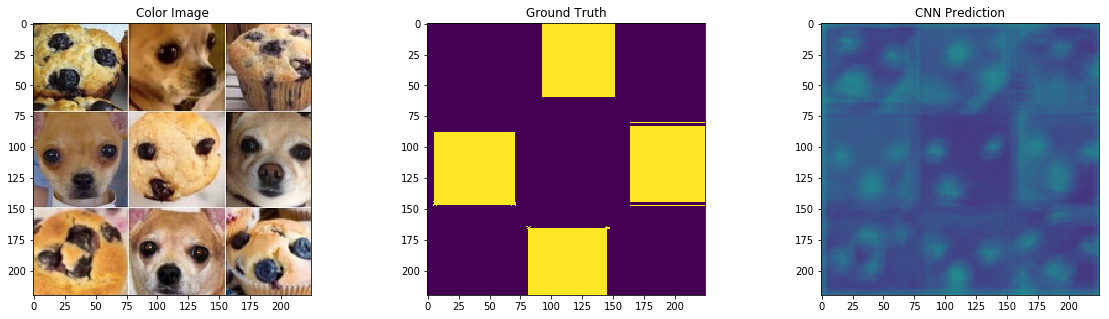

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(rgb_img)  # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, vmin=0, vmax=1, cmap='viridis')  # show the segments
ax2.set_title("Ground Truth")
m_output = simple_model.predict(img_tensor)
ax3.imshow(m_output[0, :, :, 0], vmin=0, vmax=1, cmap='viridis')
ax3.set_title("CNN Prediction");

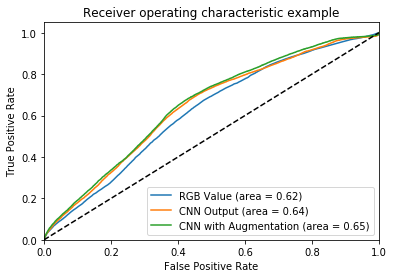

In [16]:
fpr_aug, tpr_aug, _ = roc_curve(ground_truth_labels, m_output.ravel())
roc_auc_aug = auc(fpr_aug, tpr_aug)

fig, ax = plt.subplots(1, 1)
ax.plot(fpr, tpr, label='RGB Value (area = %0.2f)' % roc_auc)
ax.plot(fpr_cnn, tpr_cnn, label='CNN Output (area = %0.2f)' % roc_auc_cnn)
ax.plot(fpr_aug, tpr_aug, label='CNN with Augmentation (area = %0.2f)' % roc_auc_aug)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

## What did the model learn?
We can look at the exact convolutions the model learned by using the `get_weights` on the layer we are interested in

In [17]:
W,  = simple_model.layers[0].get_weights()
print('Convolution:', W.shape, W.mean(), W.std())

Convolution: (12, 12, 3, 1) -0.0042214566 0.020014172


Text(0.5, 1.05, 'Blue Kernel')

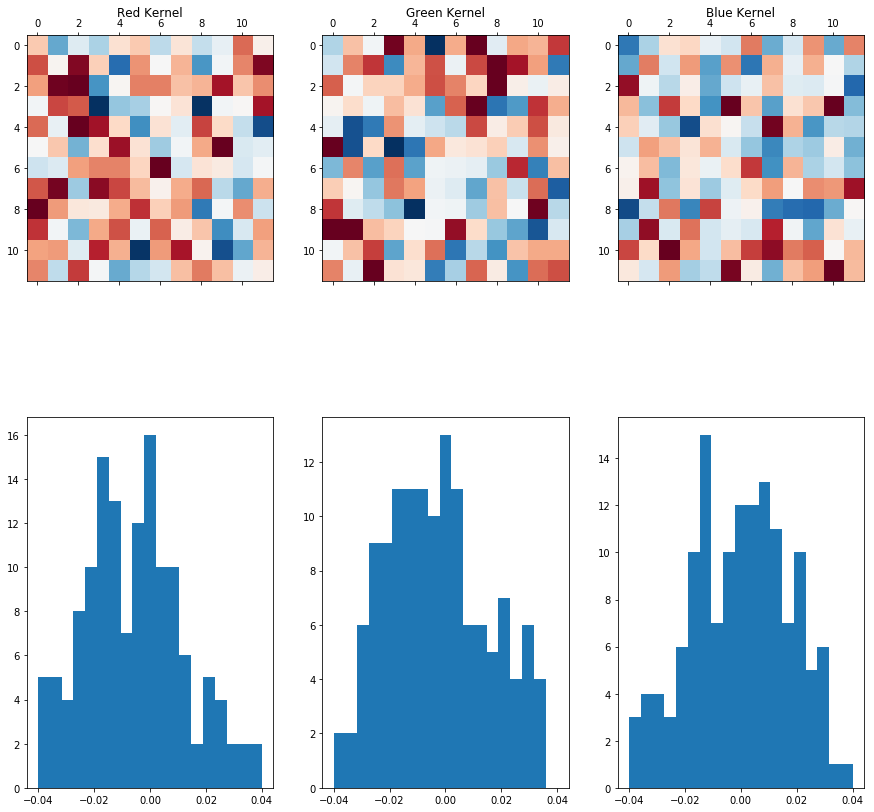

In [18]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 15))
plt_kwargs = dict(cmap='RdBu', vmin=-W.std()*2, vmax=+W.std()*2)
bins = np.linspace(plt_kwargs['vmin'], plt_kwargs['vmax'], 20)
ax1.matshow(W[:, :, 0, 0], **plt_kwargs)
ax4.hist(W[:, :, 0, 0].ravel(), bins)
ax1.set_title('Red Kernel')

ax2.matshow(W[:, :, 1, 0], **plt_kwargs)
ax5.hist(W[:, :, 1, 0].ravel(), bins)
ax2.set_title('Green Kernel')

ax3.matshow(W[:, :, 2, 0], **plt_kwargs)
ax6.hist(W[:, :, 2, 0].ravel(), bins)
ax3.set_title('Blue Kernel')

### Tasks
1. How can you improve the neural network model (what can you add, or change)?
2. Where might morphological operations fit in?
3. What is wrong with our approach for validating the model here? (what data are we using to measure the accuracy)
4. What is the loss and how is it being used?

